## Hyperparameter tuning

In this script, we will tune the model's hyperparameters to fit it as best as possible to the data, while avoiding overfitting. To that aim, we will try to optimise the different parameters (learning rate, batch and epoch sizes, number of layers, number of latent dimensions...) by trying different values for each and choosing the best combination of parameters, i.e. which different values work best together. 

If performing a grid search is the most exhaustive option, i.e. trying each value for each parameter and each possible combination of parameters, this is very computationally heavy and not realistic for large datasets. We will therefore use a random search, randomly exploring some combinations as to reduce the computational load. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
import itertools, random
import os
import json

# homemade functions and scripts
import model_ae
import utils

c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and script preparation

We will use the low-grade gliomas and glioblastoma cancer data from TCGA, which we previously preprocessed and merged. The expression data is available as `../data/merged_expression.csv`. We want to optimise the autoencoder on this bulkRNA-Seq transcriptome profiling. 

In order to tune our model, we will encapsulate the model definition and training procedure in a separate script, `model_ae.py` which we will call many times for each parameter combination explored. We will define the different parameters we want to tune (flags), as well as the different values we want to explore for each parameter. We also include callbacks such as early stopping and learning-rate reduction to stabilize training and avoid overfitting.

`model_ae.py` handles is split into 5 main functions: 
- data preparation (loading, train-test split and scaling)
- model definition 
- callbacks definition 
- model training 
- model evaluation

In [8]:
# defining a parameter name map for clearer visualisation
params_name_map = {
    "enc_units1": "Dimension 1st encoder layer",
    "enc_units2": "Dimension 2nd encoder layer",
    "enc_units3": "Dimension 3rd encoder layer",
    "latent_dim": "Dimension latent layer",
    "dec_units1": "Dimension 1st decoder layer",
    "dec_units2": "Dimension 2nd decoder layer",
    "dec_units3": "Dimension 3rd decoder layer",
    "lr": "Learning rate",
    "batch_size": "Batch size",
    "drop1": "Dropout"
}

## Run the baseline experiment 

We first run a single configuration to establish a reference point, to which all future combinations can be compared in order to identify the best combination. We will keep track of all runs in a dedicated directory so that we can compare them later.

For our baseline run, we will choose a simple symmetric autoencoder (i.e. identical number of layers in the encoder and decoder), with two layers for both the encoder and decoder. We will use the default values for the rest of the parameters: adam optimiser, ReLU activation, 20% dropout and learning rate of 1e-3. 

The callbacks parameters (early stopping and reduce on plateau) have been fixed and won't be tuned. We will only focus on the most determining parameters as to optimise the tuning and control the computational load as much as possible.

In [2]:
# update default model_ae.py parameters for baseline run
model_ae.params.update({
    "enc_units1": 512,
    "enc_units2": 128,
    "enc_units3":0
})

# baseline run

# load data
X_train, X_test, y_train, y_test = model_ae.load_data()

# build model using updated parameters
model = model_ae.build_ae(X_train, model_ae.params)

# train model
history = model_ae.train_ae(model, X_train, model_ae.params)

# evaluate
model_ae.evaluate_ae(model, X_test)


Reconstruction metrics — MSE=0.2897, MAE=0.3867, RMSE=0.5382


{'mse': 0.2896529402780437,
 'mae': 0.3866561140160169,
 'rmse': np.float64(0.5381941473836777)}

We can see that our baseline run reached a validation MSE of 0.29. We will now tune our hyperparameters to try to optimise our model, which should result in decreasing the validation loss. We will therefore retrain the model with different parameters, always keeping the same `X_train` and `X_test` sets defined above for reproducibility purpose. 

## Explore the space 

We will now try out several parameter values and combinations using a random search, searching over 60% of the grid to keep the runtime reasonable while still exploring useful combinations. we will explore: 
- the architecture shape, looking at a symmetric vs asymmetric shape as well as a shallow vs deeper model
- the dimensions of the latent space, identifying a good trade off between compressing the data while conserving a biological meaning 
- avoiding long runtimes and overfitting 

In order to keep the search computationally fast, we will first focus on tuning the architecture shape and latent dimensions, most important parameters to tune, and then fine tune it with additional parameters. 

#### Stage 1

In [3]:
search_space1 = {
    "enc_units1": [512, 256],
    "enc_units2": [256, 128, 0],
    "latent_dim": [16, 32, 64],
    "dec_units1": [128, 256],
    "dec_units2": [256, 0]
}

In [4]:
# first search 

#generate parameter combinations and sample 60%
sampled_combinations1 = utils.sample_combinations(search_space1)
print(len(sampled_combinations1))

#run each sampled combination and save results
results_stage1 = []

for params in sampled_combinations1:
    model_ae.params.update(params)

    model = model_ae.build_ae(X_train, model_ae.params)
    history = model_ae.train_ae(model, X_train, model_ae.params)
    val_loss = model_ae.evaluate_ae(model, X_test)
    metrics = model_ae.evaluate_ae(model, X_test)

    # save run outcome
    results_stage1.append({
        "params": model_ae.params.copy(),
        **metrics,
        "model": model   # keep object in memory 
    })


43
Reconstruction metrics — MSE=0.2910, MAE=0.3877, RMSE=0.5395
Reconstruction metrics — MSE=0.2910, MAE=0.3877, RMSE=0.5395
Reconstruction metrics — MSE=0.2626, MAE=0.3695, RMSE=0.5125
Reconstruction metrics — MSE=0.2626, MAE=0.3695, RMSE=0.5125
Reconstruction metrics — MSE=0.2935, MAE=0.3889, RMSE=0.5417
Reconstruction metrics — MSE=0.2935, MAE=0.3889, RMSE=0.5417
Reconstruction metrics — MSE=0.2934, MAE=0.3894, RMSE=0.5417
Reconstruction metrics — MSE=0.2934, MAE=0.3894, RMSE=0.5417
Reconstruction metrics — MSE=0.2844, MAE=0.3830, RMSE=0.5333
Reconstruction metrics — MSE=0.2844, MAE=0.3830, RMSE=0.5333
Reconstruction metrics — MSE=0.2957, MAE=0.3912, RMSE=0.5438
Reconstruction metrics — MSE=0.2957, MAE=0.3912, RMSE=0.5438
Reconstruction metrics — MSE=0.3232, MAE=0.4084, RMSE=0.5685
Reconstruction metrics — MSE=0.3232, MAE=0.4084, RMSE=0.5685
Reconstruction metrics — MSE=0.3161, MAE=0.4040, RMSE=0.5623
Reconstruction metrics — MSE=0.3161, MAE=0.4040, RMSE=0.5623
Reconstruction metric

=== Metric Summary ===
             mse        mae       rmse
count  43.000000  43.000000  43.000000
mean    0.296426   0.391476   0.544075
std     0.022168   0.014860   0.020457
min     0.253136   0.361887   0.503126
25%     0.283953   0.382637   0.532872
50%     0.293398   0.389413   0.541662
75%     0.317982   0.406237   0.563897
max     0.333234   0.416831   0.577264 



c:\Users\themi\programming\aida\deep_learning\project\scripts\utils.py:116: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


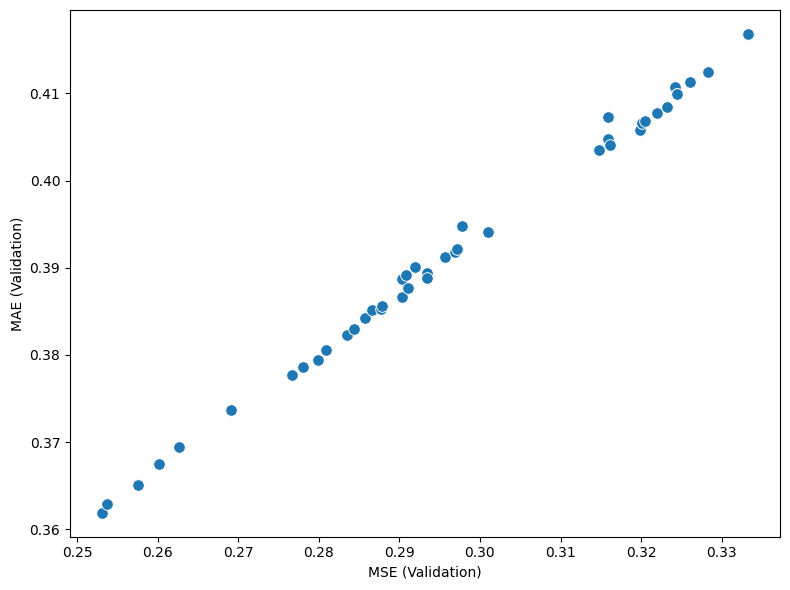

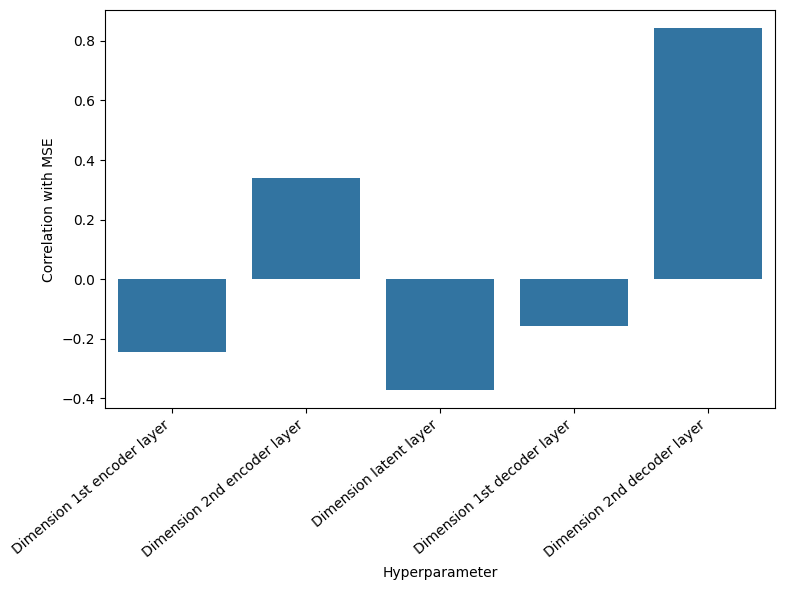

In [15]:
# exploring the tuning results from stage 1
results = utils.explore_tuning(search_space1, results_stage1, param_name_map=params_name_map)

43 models were evaluated during the first stage of tuning. The validation loss (calculation of MSE on the validation set) ranged between 0.25 and 0.32, with a mean of 0.29. The dimensions of the first encoder and decoder layers appeared slightly correlated with the validation loss. The second layer of the encoder, and even stronger for the decoder's dimensions seemed positively correlated with the validation loss. However, the dimension of the latent space appeared negatively correlated with the validation loss. Overall, it seems that limiting the dimensions of the second encoder and decoder layers, as well as widening the latent space dimensions, would minimise the validation loss. 

We will investigate the three models with the minimum validation loss, i.e. minimal reconstruction error of the data and look at the parameters chosen. 

In [12]:
# looking at the parameters of each top3 models (by lowest validation loss)
results_stage1 = sorted(results_stage1, key=lambda r: r["mse"])
top3 = results_stage1[:3]

top3_df = pd.DataFrame([
    {**r["params"], "mse": r["mse"]} for r in top3
])
print(top3_df)

   enc_units1  enc_units2  enc_units3  drop1  latent_dim  dec_units1  \
0         512           0           0    0.2          64         128   
1         512           0           0    0.2          64         256   
2         256           0           0    0.2          64         256   

   dec_units2  dec_units3  seed activation optimizer     lr  epochs  \
0           0           0    22       relu      adam  0.001     200   
1           0           0    22       relu      adam  0.001     200   
2           0           0    22       relu      adam  0.001     200   

   batch_size  val_split       mse  
0          16        0.2  0.253136  
1          16        0.2  0.253714  
2          16        0.2  0.257603  


Indeed we can see that the three most performing parameter combinations only have one layer in both the encoder and decoder. The maximum latent dimension has been chosen (64). The dropout was fixed to 0.2. 

The three top models show very similar parameters, only differing in the dimension of the first encoder and decoder layers. They also show a very similar validation loss, hence it seems that either these dimensions is suitable for our dataset. 

We will save the three top models. However, since fine-tuning is long and computationally heavy, we will only further fine tune the first model for now and see if the second tuning step further reduces the validation loss on that model. We can see later if we need to tune another.

In [16]:
# saving the top3 tuning models 
for i, r in enumerate(top3, start=1):
    utils.save_model(r, save_dir="tuning_models", file_name=f"stage1_top{i}")

# saving all the parameter combinations and resulting validation loss
results.to_csv("tuning_models/all_models_stage1.csv", index=False)

Saved model to tuning_models\stage1_top1.keras
Saved model to tuning_models\stage1_top2.keras
Saved model to tuning_models\stage1_top3.keras


#### Stage 2

We now move on to the second tuning round. As mentioned, we will further fine tune the dimensions of the latent space, whose optimium might be higher than the max value of 64 set. Furthermore, we will also tune the dropout rate, learning rate and batch size, more general parameters which also influence the model's performance and should be tuned now that we have fixed the model's architecture. Since this is already a lot of parameters to tune, we will fix the optimiser to Adam and the activation to ReLU. 

In [17]:
# defining the search space for the second round of optimisation
search_space2 = {
    "latent_dim": [64, 96, 128],
    "lr": [1e-3, 5e-4, 1e-4],
    "batch_size": [8, 16, 32],
    "drop1": [0.0, 0.2, 0.5] #,
    #"activation": ["relu", "tanh"],
    #"optimizer": ["adam", "rmsprop"]
}

In [18]:
# generate parameter combinations and sample 60%
sampled_combinations2 = utils.sample_combinations(search_space2)
print(f"Stage-2 combinations: {len(sampled_combinations2)}")

results_stage2 = []

# fixed architecture from the best Stage 1 model
arch_params = top3[0]["params"].copy()

for train_params in sampled_combinations2:

    # merge architecture + training hyper-params
    run_params = {**arch_params, **train_params}
    model_ae.params.update(run_params)

    # train + evaluate
    model = model_ae.build_ae(X_train, model_ae.params)
    history = model_ae.train_ae(model, X_train, model_ae.params)
    metrics = model_ae.evaluate_ae(model, X_test)

    results_stage2.append({
        "params": run_params.copy(),
        **metrics,
        "model": model   # keep best model object in memory
    })


Stage-2 combinations: 48
Reconstruction metrics — MSE=0.2524, MAE=0.3590, RMSE=0.5024
Reconstruction metrics — MSE=0.2521, MAE=0.3610, RMSE=0.5021
Reconstruction metrics — MSE=0.2623, MAE=0.3705, RMSE=0.5121
Reconstruction metrics — MSE=0.2539, MAE=0.3645, RMSE=0.5039
Reconstruction metrics — MSE=0.2782, MAE=0.3796, RMSE=0.5275
Reconstruction metrics — MSE=0.2555, MAE=0.3640, RMSE=0.5054
Reconstruction metrics — MSE=0.2499, MAE=0.3573, RMSE=0.4999
Reconstruction metrics — MSE=0.2834, MAE=0.3873, RMSE=0.5324
Reconstruction metrics — MSE=0.3393, MAE=0.4298, RMSE=0.5825
Reconstruction metrics — MSE=0.2402, MAE=0.3507, RMSE=0.4901
Reconstruction metrics — MSE=0.2506, MAE=0.3607, RMSE=0.5006
Reconstruction metrics — MSE=0.2511, MAE=0.3600, RMSE=0.5010
Reconstruction metrics — MSE=0.2709, MAE=0.3758, RMSE=0.5205
Reconstruction metrics — MSE=0.2871, MAE=0.3914, RMSE=0.5358
Reconstruction metrics — MSE=0.2404, MAE=0.3513, RMSE=0.4903
Reconstruction metrics — MSE=0.3378, MAE=0.4285, RMSE=0.5812

=== Metric Summary ===
             mse        mae       rmse
count  48.000000  48.000000  48.000000
mean    0.277326   0.381364   0.525906
std     0.029740   0.023768   0.027666
min     0.240183   0.350671   0.490085
25%     0.252333   0.360556   0.502327
50%     0.272263   0.375833   0.521787
75%     0.289155   0.393270   0.537731
max     0.351680   0.436561   0.593026 



c:\Users\themi\programming\aida\deep_learning\project\scripts\utils.py:116: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


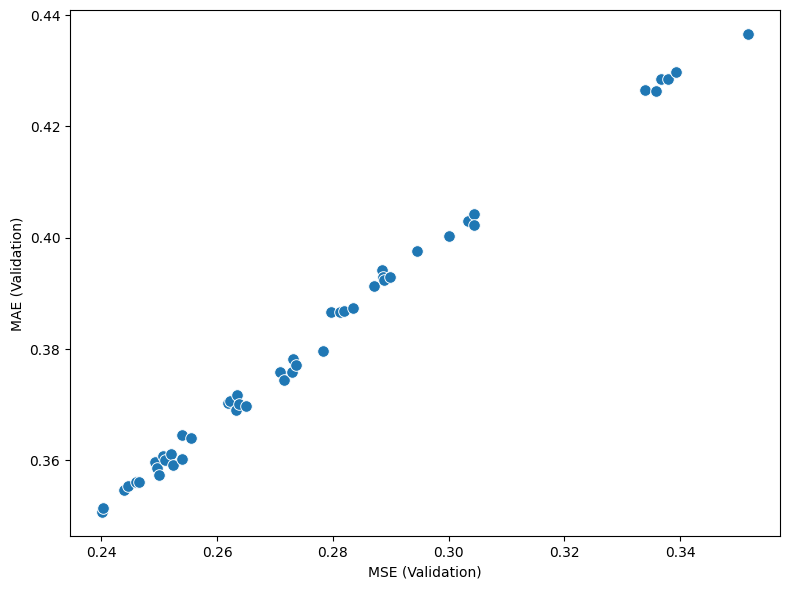

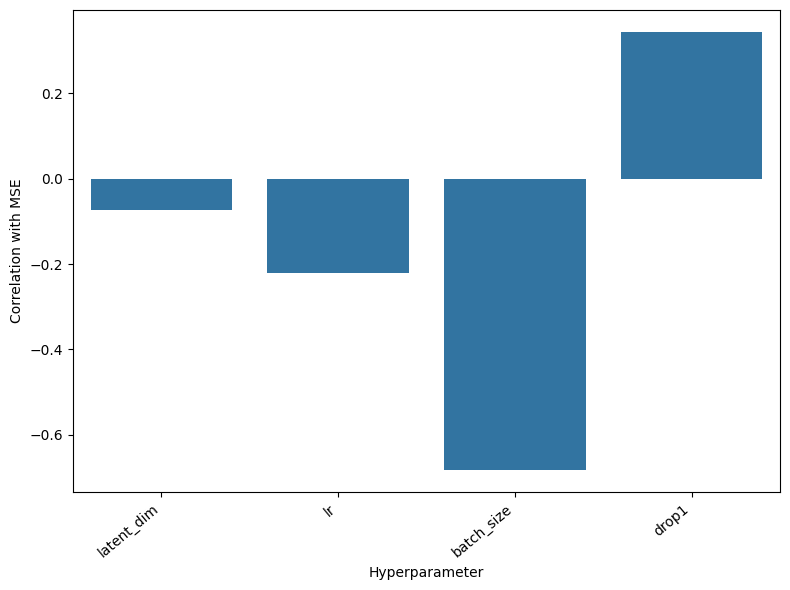

In [23]:
# exploring the tuning results from stage 2
results = utils.explore_tuning(search_space2, results_stage2, stage_name="Stage 2")

In [24]:
# looking at the parameters of each top3 models (by lowest validation loss)
results_stage2 = sorted(results_stage2, key=lambda r: r["mse"])
top3 = results_stage2[:3]

top3_df = pd.DataFrame([
    {**r["params"], "mse": r["mse"]} for r in top3
])
print(top3_df)


   enc_units1  enc_units2  enc_units3  drop1  latent_dim  dec_units1  \
0         512           0           0    0.2          96         128   
1         512           0           0    0.2         128         128   
2         512           0           0    0.0         128         128   

   dec_units2  dec_units3  seed activation optimizer      lr  epochs  \
0           0           0    22       relu      adam  0.0010     200   
1           0           0    22       relu      adam  0.0005     200   
2           0           0    22       relu      adam  0.0010     200   

   batch_size  val_split       mse  
0          32        0.2  0.240183  
1          32        0.2  0.240355  
2          32        0.2  0.243865  


In [25]:
# isolating the best run
top1 = top3[0]
print("Best Stage-2 config:", top1["params"])
print("Val loss:", top1["mse"])

Best Stage-2 config: {'enc_units1': 512, 'enc_units2': 0, 'enc_units3': 0, 'drop1': 0.2, 'latent_dim': 96, 'dec_units1': 128, 'dec_units2': 0, 'dec_units3': 0, 'seed': 22, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001, 'epochs': 200, 'batch_size': 32, 'val_split': 0.2}
Val loss: 0.2401830298542816


We can see a much narrower distribution of the validation losses for this second tuning step, which suggests that this step further fine tuned the model on some more subtle parameters. The validation loss ranged from 0.23 to 0.30, with an average of 0.26, i.e. on average better than during the first tuning step. The best model during the first step (loss = 0.254) was further improved to reach a validation loss of 0.239. 

The learning rate and dropout seemed to have very little impact on the validation loss for our model. The latent dimension showed a smaller correlation to the loss than before, suggesting that this bigger range was more suited to the data. The final model has a latent dimension of 96. The batch size, however, was strongly negatively correlated to the validation loss. The maximal batch size was chosen in the final model. 

Since we do not know if a batch size of 32 is optimal, or if it was just the maximal value suggested in the model, we will perform a third round of tuning, only trying bigger values for the batch size. 

In [26]:
# saving stage 2 best model 
utils.save_model(top1, save_dir="tuning_models", file_name=f"stage2_top1")

# saving all the parameter combinations and resulting validation loss
results.to_csv("tuning_models/all_models_stage2.csv", index=False)

Saved model to tuning_models\stage2_top1.keras


#### Stage 3 

As mentioned, we will finally perform a last tuning of the batch size, since it seemed to have an impact on the validation loss for our data. 

In [27]:
# defining the explored batch sizes 
batch_sizes = [32, 64, 128, 256]

In [28]:
# third search (based on the previous model)

batch_results = []

for bs in batch_sizes:
    # update parameters: keep best params + add batch size
    model_ae.params.update(top1["params"])
    model_ae.params["batch_size"] = bs

    model = model_ae.build_ae(X_train, model_ae.params)
    history = model_ae.train_ae(model, X_train, model_ae.params)
    metrics = model_ae.evaluate_ae(model, X_test)

    batch_results.append({
        "model": model,
        "params": model_ae.params,
        **metrics
    })

    print(f"Batch size {bs}: val_loss={metrics["mse"]:.4f}")


Reconstruction metrics — MSE=0.2431, MAE=0.3533, RMSE=0.4930
Batch size 32: val_loss=0.2431
Reconstruction metrics — MSE=0.2364, MAE=0.3478, RMSE=0.4862
Batch size 64: val_loss=0.2364
Reconstruction metrics — MSE=0.2324, MAE=0.3448, RMSE=0.4821
Batch size 128: val_loss=0.2324
Reconstruction metrics — MSE=0.2440, MAE=0.3546, RMSE=0.4940
Batch size 256: val_loss=0.2440


In [29]:
# identifying optimal batch size
best_batch = min(batch_results, key=lambda r: r["mse"])

# save best tuned model 
utils.save_model(best_batch, save_dir="tuning_models", file_name=f"stage3_top1")

Saved model to tuning_models\stage3_top1.keras


We have now optimised the important hyperparameters of our autoencoder, which seems to perform well on the data, with a validation loss of... 

Now, we will keep those optimal parameters to retrain our model and save it. 

## Retraining the best configuration

Based on the tuning, we will train a fresh model with the set of chosen parameters. 

In [31]:
# --- Build model with best parameters ---
best_params = best_batch["params"]  # from the last model
model_ae.params.update(best_params)
final_model = model_ae.build_ae(X_train, model_ae.params)

# --- Train the model ---
final_history = model_ae.train_ae(final_model, X_train, model_ae.params)

# --- Evaluate ---
final_metrics = model_ae.evaluate_ae(final_model, X_test)
print(f"Final model test loss: {final_metrics["mse"]:.4f}")

Reconstruction metrics — MSE=0.2425, MAE=0.3528, RMSE=0.4925
Final model test loss: 0.2425


## Saving and reloading the final model 

Finally, we save the model. We also reload the model and re-evaluate it on the test data to make sure that saving the model went well and our model can be used in other scripts. 


In [32]:
utils.save_model({
        "model": final_model,
        "params": model_ae.params,
        **final_metrics
    },
    save_dir="final_model",
    file_name="final_ae"

)

Saved model to final_model\final_ae.keras


In [33]:
reloaded = load_model("final_model/final_ae.keras")
reloaded.evaluate(X_test, X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2425 


0.24251674115657806

We can see that the test performance on our test set is similar to the loss obtained previously. Our model has been correctly saved and can be used for further analysis. 

## Saving the latent embeddings and reconstruction

We will also extract the latent space as well as the reconstruction of the data, in order to save all the information and enable a clear, reproducible analysis of the results. 

In [34]:
# loading the final model
model = load_model("final_model/final_ae.keras")

# extracting encoder part
encoder = Model(
    inputs=model.input,
    outputs=model.get_layer("latent").output,
    name="encoder_model"
)

# saving latent representations + reconstructions
Z_train = encoder.predict(X_train)
print(Z_train.shape)
Z_test  = encoder.predict(X_test)
print(Z_test.shape)

X_train_rec = model.predict(X_train)
print(X_train_rec.shape)
X_test_rec  = model.predict(X_test)
print(X_test_rec.shape)

np.save("final_model/Z_train.npy", Z_train)
np.save("final_model/Z_test.npy", Z_test)
np.save("final_model/X_train_rec.npy", X_train_rec)
np.save("final_model/X_test_rec.npy", X_test_rec)

print("Saved latent + reconstruction arrays.")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(740, 96)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(185, 96)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(740, 2000)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
(185, 2000)
Saved latent + reconstruction arrays.


We have now trained our autoencoder model and saved all necessary model, embeddings and reconstructions necessary for the analysis. 